# CS 484 Final Project

Plan:
1. read some more papers and find all the datasets
  a) we can use resnet50 as encoder, and then I think we build a more complicated decoder
2. try to see if we can get an overfitted model to work
3. try to see if we can extend that model
4. Great Success


## Abstract

TODO

In [3]:
# Importing essential libraries for basic image manipulations.
import numpy as np
import PIL
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from tqdm import tqdm

# We import some of the main PyTorch and TorchVision libraries.
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF
from torchvision.datasets._stereo_matching import Kitti2015Stereo
import torchvision.models as models

## Data Synthesis

We will be using the [KITTI stereo dataset](https://www.cvlibs.net/datasets/kitti/eval_scene_flow.php?benchmark=stereo) for stereo disparity pairs.

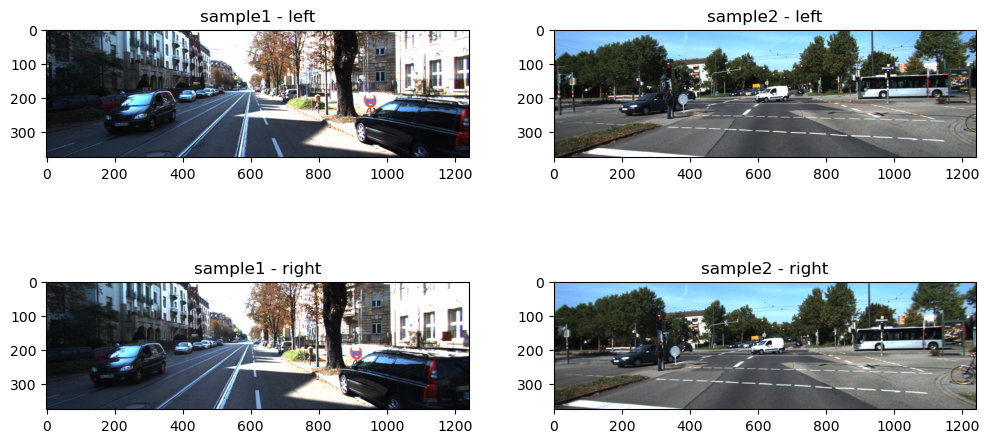

In [21]:
# Importing the KITTY dataset

DATASET_PATH = 'datasets'

# Create a dataloader to load in images
sample1 = Kitti2015Stereo(root=DATASET_PATH)[0]
sample2 = Kitti2015Stereo(root=DATASET_PATH)[30]

left1, right1, _, _ = sample1
left2, right2, _, _ = sample2

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
plt.title('sample1 - left')
ax1.imshow(left1)
ax2 = fig.add_subplot(2,2,3)
plt.title('sample1 - right')
ax2.imshow(right1)
ax3 = fig.add_subplot(2,2,2)
plt.title('sample2 - left')
ax3.imshow(left2)
ax4 = fig.add_subplot(2,2,4)
plt.title('sample2 - right')
ax4.imshow(right2)


## Model

We will use the fully convolutional network described by the paper referenced in the slides. The model devides into an encoder and decoder. At a high level, the encoder recognizes featueres and the decoder reconstructs a disparity map given these identified features. The decoder uses *transposed convolutions* to learn how to upsample at each step, instead of just upsampling via bilinear interpolation, for example.

In [ ]:
### model
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        # Miscelaneous functions
        self.act_fn = nn.ReLU(inplace=True)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear')

        # Encoder
        self.conv1  = nn.Conv2d(3  , 32 , kernel_size=7, stride=2, padding=3)
        self.conv1b = nn.Conv2d(32 , 32 , kernel_size=7, stride=1, padding=3)

        self.conv2  = nn.Conv2d(32 , 64 , kernel_size=5, stride=2, padding=2)
        self.conv2b = nn.Conv2d(64 , 64 , kernel_size=5, stride=1, padding=2)

        self.conv3  = nn.Conv2d(64 , 128, kernel_size=3, stride=2, padding=1)
        self.conv3b = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        self.conv4  = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv4b = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.conv5  = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.conv5b = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        self.conv6  = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
        self.conv6b = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        
        self.conv7  = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
        self.conv7b = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        # Decoder
        self.upconv7 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.iconv7  =          nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1)
        self.upconv6 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.iconv6  =          nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1)
        self.upconv5 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.iconv5  =          nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.upconv4 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.iconv4  =          nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.disp4   =          nn.Conv2d(128, 2, kernel_size=3, stride=1, padding=1)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.iconv3  =          nn.Conv2d(128 + 2, 64, kernel_size=3, stride=1, padding=1)
        self.disp3   =          nn.Conv2d(64, 2, kernel_size=3, stride=1, padding=1)
        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.iconv2  =          nn.Conv2d(64 + 2, 32, kernel_size=3, stride=1, padding=1)
        self.disp2   =          nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1)
        self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.iconv1  =          nn.Conv2d(16 + 2, 16, kernel_size=3, stride=1, padding=1)
        self.disp1   =          nn.Conv2d(16, 2, kernel_size=3, stride=1, padding=1)

    def forward(self, left_image):
        # Encoder
        # Note how some layer are cached for skip connections
        x      = self.act_fn(self.conv1(left_image))
        conv1b = self.act_fn(self.conv1b(x))
        x      = self.act_fn(self.conv2(conv1b))
        conv2b = self.act_fn(self.conv2b(x))
        x      = self.act_fn(self.conv3(conv2b))
        conv3b = self.act_fn(self.conv3b(x))
        x      = self.act_fn(self.conv4(conv3b))
        conv4b = self.act_fn(self.conv4b(x))
        x      = self.act_fn(self.conv5(conv4b))
        conv5b = self.act_fn(self.conv5b(x))
        x      = self.act_fn(self.conv6(conv5b))
        conv6b = self.act_fn(self.conv6b(x))
        x      = self.act_fn(self.conv7(conv6b))
        conv7b = self.act_fn(self.conv7b(x))

        # Decoder
        x     = self.act_fn(self.upconv7(conv7b))
        x     = self.act_fn(self.iconv7(torch.cat([x, conv6b], dim=1)))
        x     = self.act_fn(self.upconv6(x))
        x     = self.act_fn(self.iconv6(torch.cat([x, conv5b], dim=1)))
        x     = self.act_fn(self.upconv5(x))
        x     = self.act_fn(self.iconv5(torch.cat([x, conv4b], dim=1)))  
        x     = self.act_fn(self.upconv4(x)) 
        x     = self.act_fn(self.iconv4(torch.cat([x, conv3b], dim=1)))  
        disp4 = self.act_fn(self.disp4(x))
        x     = self.act_fn(self.upconv3(x))
        x     = self.act_fn(self.iconv3(torch.cat([x, conv2b, self.upsample2(disp4)], dim=1)))
        disp3 = self.act_fn(self.disp3(x))
        x     = self.act_fn(self.upconv2(x))
        x     = self.act_fn(self.iconv2(torch.cat([x, conv1b, self.upsample2(disp3)]))) 
        disp2 = self.act_fn(self.disp2(x))  
        x     = self.act_fn(self.upconv1(x))
        x     = self.act_fn(self.iconv1(torch.cat([x, self.upsample2(disp2)])))
        disp1 = self.act_fn(self.disp1(x))

        return disp1

## Loss Function

## Validation

## Training

In [ ]:
%%time

# The whole training on a single image (20-40 epochs) should take only a minute or two on a CPU (and a few seconds on GPU).
# Below we create a (deep) copy of untrained_net and train it on a single training image (leading to gross overfitting).
# Later, we will create a separate (deep) copy of untrained_net to be trained on full training dataset.
# NOTE: Normally, one can create a new net via declaration new_net = MyNet(21). But, randomization of weights when new nets
# are declared that way creates *different* untrained nets. This notebook compares different versions of network training.
# For this comparison to be direct and fair, it is better to train (deep) copies of the exact same untrained_net.
overfit_net = copy.deepcopy(untrained_net)

# You can change the number of EPOCHS
EPOCH = 40

# switch to train mode (original untrained_net was set to eval mode)
overfit_net.train()

optimizer = get_optimizer(overfit_net)

print("Starting Training...")

loss_graph = []

fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax = fig.add_subplot(1,1,1)

for e in range(EPOCH):
    loss = train(sanity_loader, overfit_net, optimizer, loss_graph)
    ax.clear()
    ax.set_xlabel('iterations')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss curve for OVERFIT_NET')
    ax.plot(loss_graph, label='training loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()
    print("Epoch: {} Loss: {}".format(e, loss))
torch.save(overfit_net.state_dict(), "overfit_net.pth")
torch.save(untrained_net.state_dict(), "untrained_net.pth")

## Evaluation

## Conclusion

TODO